In [202]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Masking, Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler #to normalize data
from os.path import exists
import seaborn as sns
import datetime
from datetime import date

In [210]:
df = pd.read_csv('LMT_5YR.csv',parse_dates=["Date"])
df_dividend=pd.read_csv('LMT_5YR_Dividend.csv',parse_dates=["Date"])

filter=df["Date"]>"1/1/2017"
df=df[filter]

filter=df_dividend["Date"]>"1/1/2017"
df_dividend=df_dividend[filter]

print("Dividend Count",len(df_dividend))

df=pd.merge(df,df_dividend,on="Date",how="left").fillna(0)
print(df[df["Dividends"]>0].head(10))
df.set_index("Date",inplace=True)

df['Year']=df.index.to_period('Y')

print(df['Year'].head(5))



Dividend Count 22
          Date        Open        High         Low       Close   Adj Close  \
37  2017-02-27  265.000000  270.000000  264.200012  269.359985  234.698196   
101 2017-05-30  281.829987  282.839996  279.730011  280.089996  245.623474   
166 2017-08-30  306.420013  307.220001  305.500000  306.299988  270.204102   
230 2017-11-30  319.619995  320.940002  318.480011  319.119995  283.279633   
290 2018-02-28  357.359985  359.200012  352.420013  352.440002  314.614227   
354 2018-05-31  319.239990  320.279999  314.470001  314.540009  282.542053   
419 2018-08-31  318.559998  320.890015  317.010010  320.410004  289.614624   
482 2018-11-30  300.750000  303.529999  297.880005  300.429993  273.544861   
541 2019-02-28  307.440002  311.750000  306.119995  309.410004  283.750824   
605 2019-05-31  337.589996  341.140015  337.489990  338.540009  312.475403   

      Volume  Dividends  
37   1499700       1.82  
101   902200       1.82  
166  1273000       1.82  
230  2626200       

In [211]:
print("We will invest $1000 in lmt")
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
#df = df.reset_index()

#get the first open price
first_date=df.index.min()
shares=float(investment)/float(df[df.index==first_date]["Open"])
print("Initial Share count",shares)
investment=1000
df['open_accum'] = (df[['Open']].pct_change()+1).cumprod()
df['open_accum']=df['open_accum'].astype(float)
df['open_accum']=df['open_accum'].mul(investment)
df['open_accum']=df['open_accum']+df['Dividends']*shares
df['open_accum']=df['open_accum'].fillna(0)
df['open_pct_change']=df['Open'].pct_change()

#filter=df["Open"]==0
#df.drop(df[filter].index, inplace = True)

print(df.shape)



We will invest $1000 in lmt
Initial Share count 3.98089176728772
(1414, 10)


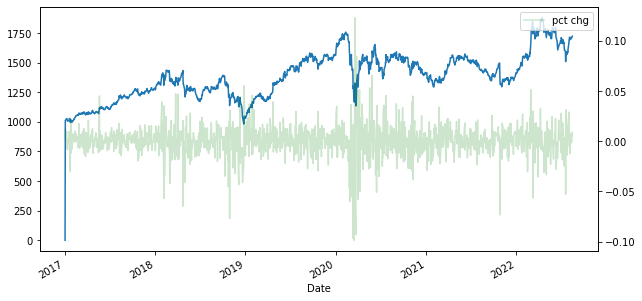

In [212]:
fig,ax = plt.subplots(figsize=(10,5)) 

df['open_accum'].plot(ax=ax,label="accumulation")
twinx=ax.twinx()
df['open_pct_change'].plot(ax=twinx,c='g',alpha=0.2,label="pct chg")
plt.legend()
plt.show()

          Date  Dividends
131 2017-02-27       1.82
132 2017-05-30       1.82
133 2017-08-30       1.82
134 2017-11-30       2.00
135 2018-02-28       2.00
136 2018-05-31       2.00
137 2018-08-31       2.00
138 2018-11-30       2.20
139 2019-02-28       2.20
140 2019-05-31       2.20


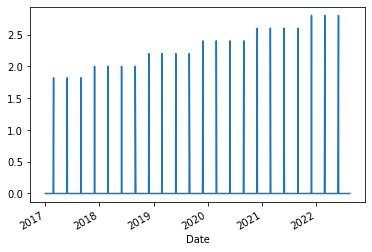

In [213]:
df["Dividends"].plot()
print(df_dividend.head(10))

1414


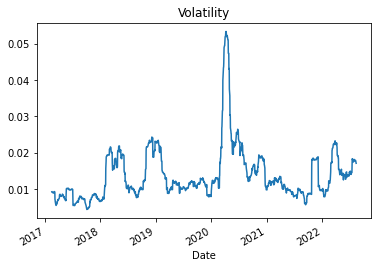

In [215]:
print(len(df))
rolling=df['open_pct_change'].rolling(30)
volatility=rolling.std().dropna()
volatility.plot()
plt.title("Volatility")
plt.show()

In [216]:
df["open_pct_positive_count"]=0

#######caculate the occurrences of positive open
for index in range(len(df)):
    count=0
    for index2 in (range(index,0,-1)):
        if df.iloc[index2]["open_pct_change"]>0:
            count=count+1
        else:
            break
    df.iloc[index, df.columns.get_loc('open_pct_positive_count')]=count
    
print(df[df["open_pct_positive_count"]>0])    


df["buy_count"]=0

for index in range(len(df)):
    count=0
    for index2 in (range(index,0,-1)):
        if df.iloc[index2]["open_pct_change"]>0:
            count=count+1
        else:
            break
    df.iloc[index, df.columns.get_loc('buy_count')]=count
    
df['action']=[ 'Sell' if x['buy_count']==0 else 'Buy' if x['buy_count']==2 else 'Hold' if x['buy_count'] > 2 else 'No Action' for key,x in df.iterrows()]
                
df["target"]=0
for index in range(len(df)):
    action=df.iloc[index]["action"]
    if (action=='Buy'):
             df.iloc[index, df.columns.get_loc('target')]=1
    elif (action=='Sell'):
             df.iloc[index, df.columns.get_loc('target')]=2
        
buy_list=df[df["target"]==1]
for index,item in buy_list.iterrows():
    print(index,item["Open"],item["open_pct_positive_count"])
    
print("buy count is when pct chg is postive for more than two consecutive days")

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-01-04  254.100006  254.899994  253.339996  253.990005  219.791855   
2017-01-05  254.369995  258.019989  254.100006  255.979996  221.513901   
2017-01-06  255.479996  258.570007  255.479996  257.850006  223.132172   
2017-01-09  258.000000  258.989990  257.429993  257.809998  223.097534   
2017-01-10  258.160004  258.959991  256.170013  256.170013  221.678345   
...                ...         ...         ...         ...         ...   
2022-08-03  427.269989  431.760010  419.640015  429.299988  429.299988   
2022-08-04  430.709991  434.649994  426.890015  428.130005  428.130005   
2022-08-08  427.500000  429.369995  421.679993  423.859985  423.859985   
2022-08-10  430.070007  432.250000  426.339996  429.989990  429.989990   
2022-08-15  432.679993  439.970001  429.859985  438.010010  438.010010   

             Volume  Dividends  Year 

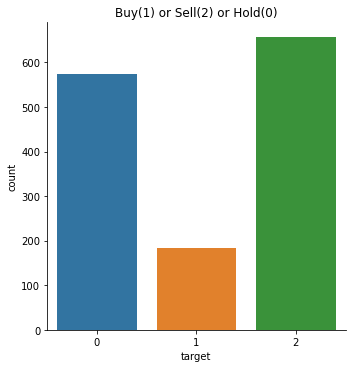

You want to find a stock where Hold counts are high


In [217]:
g=sns.catplot(x="target",data=df,kind="count")  #buy
plt.title('Buy(1) or Sell(2) or Hold(0)')
plt.show()

print('You want to find a stock where Hold counts are high')

    open_pct_positive_count  Incidence  Size
0                         0        2.0   657
1                         1        0.0   359
2                         2        1.0   184
3                         3        0.0   103
4                         4        0.0    53
5                         5        0.0    32
6                         6        0.0    14
7                         7        0.0     7
8                         8        0.0     2
9                         9        0.0     1
10                       10        0.0     1
11                       11        0.0     1
103
incidence show the average target value for each group


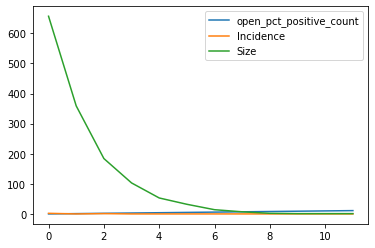

In [218]:
def create_pig_table(basetable, target, variable):
  
    # Create groups for each variable
    groups = basetable[[target,variable]].groupby(variable)
    
    pig_table=groups[target].agg([np.mean, np.size]).reset_index()
    pig_table=pig_table.rename(columns={'mean':'Incidence','size':'Size'})
    #pig_table = groups[target].agg({'Incidence' : np.mean, 'Size' : np.size}).reset_index()

    # Return the predictor insight graph table
    return pig_table

# Calculate the predictor insight graph table for the variable gender
pig_table = create_pig_table(df, "target", "open_pct_positive_count")
print(pig_table)
print(len(df[df['open_pct_positive_count']==3]))

print("incidence show the average target value for each group")

pig_table.plot()
plt.show()

In [256]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        #lstm_array.append(np.nan_to_num(data_array[start:stop, :]))
        lstm_array.append(data_array[start:stop, :])
        #print(lstm_array)
    
    return np.array(lstm_array)

def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

#print(df.columns)
#X_Columns = [column for column in df.columns if column not in["open_accum","Year"]]
X_Columns=['Open', 'Volume',
       'open_accum', 'open_pct_change', 'open_pct_positive_count',
       'buy_count']
#print(X_Columns)

min_max_scaler = MinMaxScaler(feature_range=(-1,1))

#df[X_Columns] = min_max_scaler.fit_transform(df[X_Columns])

sequence_length=50

#[print(df[df['YearQuarter']==year_quarter]) for year_quarter in df['YearQuarter'].unique()]

X_train=np.concatenate(list(list(gen_train(df[df['Year']==year], sequence_length, X_Columns)) for year in df['Year'].unique()))
print("X_train",X_train.shape)
y_train = np.concatenate(list(list(gen_target(df[df['Year']==year], sequence_length, "open_accum")) for year in df['Year'].unique()))
print("y_train",y_train.shape)

X_train (1120, 50, 6)
y_train (1120,)


In [257]:
nb_features = X_train.shape[2]

model = Sequential()
model.add(LSTM(
         units=512,
         return_sequences=True,
         input_shape=(sequence_length, nb_features)))
model.add(BatchNormalization())
model.add(Dropout(0.02))
#model.add(Dense(units=256, activation="relu"))
model.add(LSTM(          units=128,          return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.02))
model.add(Dense(units=50, activation="relu"))
model.add(Dense(units=1,activation='linear'))
#model.add(Dense(units=1, activation='relu'))
model.compile(loss="mean_absolute_error", optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 50, 512)           1062912   
                                                                 
 batch_normalization_17 (Bat  (None, 50, 512)          2048      
 chNormalization)                                                
                                                                 
 dropout_31 (Dropout)        (None, 50, 512)           0         
                                                                 
 dense_18 (Dense)            (None, 50, 256)           131328    
                                                                 
 batch_normalization_18 (Bat  (None, 50, 256)          1024      
 chNormalization)                                                
                                                                 
 dropout_32 (Dropout)        (None, 50, 256)         

In [258]:

print ("Train the model")
length=len(X_train)
path_to_file="C:\\Users\\dnishimoto\\python_files\\python-deep-learning-master\\lstm_lmt_model.h5"

file_exists = exists(path_to_file)
if(file_exists):
    model.load_weights(path_to_file)
    
history=model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1,
          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

model.save_weights(path_to_file)


Train the model
Epoch 1/10
30/32 [===========================>..] - ETA: 1s - loss: nan - accuracy: 0.0000e+00

KeyboardInterrupt: 

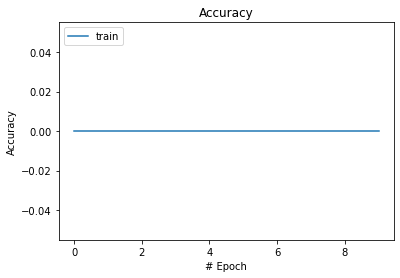

In [249]:
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_mean_squared_error'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('# Epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [250]:
scores = model.evaluate(X_train, y_train, verbose=1, batch_size=200)
print('MSE: {}'.format(scores[1]))

7/7 [==============================] - 1s 168ms/step - loss: nan - accuracy: 0.0000e+00
MSE: 0.0


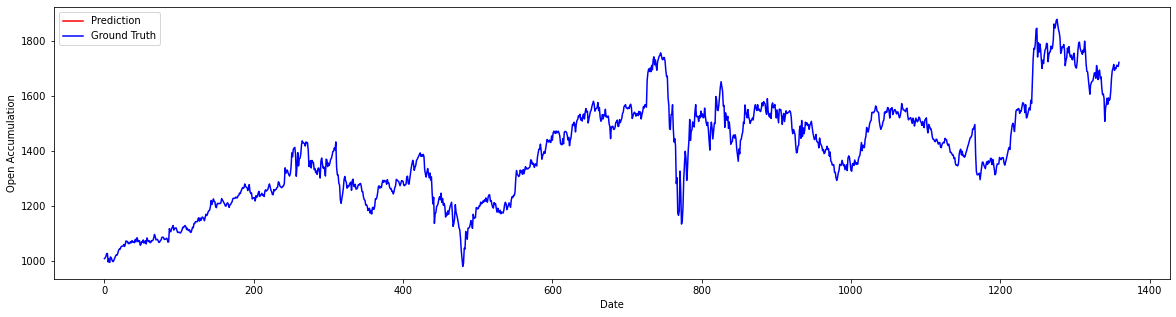

In [251]:
y_pred_test = model.predict(X_train[0:6000], verbose=0)

plt.figure(figsize=(20,5))
plt.plot(y_pred_test, color='red', label='Prediction')
plt.plot(y_train[0:6000], color='blue', label='Ground Truth')
plt.ylabel("Open Accumulation")
plt.xlabel("Date")
plt.legend(loc='upper left')
plt.show()

In [125]:
print("done!")

done!
